# Model Tuning

On previous section, we decided to try some parameter tuning on two model candidates.

These models are:

- **Candidate 3:** Random Forest on Stratified Under sampling Samples.
- **Candidate 5:** Bagging with AdaBoost Estimators on Stratified Under sampling Samples.

As you may know, both ensembles can have **multiple algorithm parameters**.
Additionally, along this process we have been working with some fixed variables like **strata proportions** or **number of estimators** in each ensemble structure.

The purpose of this section is to find a good model that hides beneath all this hyperparameter combinations.

To achieve this goal, we are going to perform a **Random Search CV** on both final candidates.
- We must consider that samples are now going to be even smaller (because of CV folds). This probably will affect overall scores since each model will have fewer data to train.
- Both candidates follow Stratified Under sample Strategy. This means that **score functions must be modified so that it translates from strata** probabilities / predictions **to target probabilities** / predictions before executing score.
- Strata proportions and number of estimators will be tested as well. This is actually the main focus to test the designed strategy.

**Note:** Random Search execution is extremely resource / time consuming. I performed an execution of 500 iterations (for Candidate 3) and 750 iterations (for Candidate 5). The results are stored in the **output/random_search** folder.

In [5]:
# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

from toolkit import Viz, Tools, PF

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score, make_scorer, precision_recall_curve

from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV

# Pre configure modules
warnings.filterwarnings('ignore')
sns.set()
random_state = 42

In [6]:
# Function to reset data to original structures. With new features added. No transformations numeric features.
def reset_data():
    data, _, _, _ = PF.import_data()
    X, y = data[PF.cat_cols + PF.num_cols], data[PF.target_col]
    X = PF.add_features(X, y)
    X = PF.prepare_features(X, num_transform=False)

    strt = X[PF.strt_col]
    X.drop(PF.cntr_cols, axis=1, inplace=True)

    return data, X, y, strt

# Get Data, Separate Training and test datasets
data, X, y, strt = reset_data()

X_train, X_test, strt_train, strt_test = train_test_split(X, strt, test_size=.2, random_state=random_state)
y_train, y_test = y[X_train.index], y[X_test.index]

---
## Tuning Prerequisites

### Define Strata Proportion Candidates
As mentioned previously, is time to test the strata proportions for sample definition. Instead of keep working on with fixed unsupported value.

In [7]:
# Define strata proportions and counts for validate best
strata_ps = [{0: 0.05, 1: 0.8, 2: 0.15}, {0: 0.1, 1: 0.75, 2: 0.15},
             {0: 0.05, 1: 0.75, 2: 0.2}, {0: 0.1, 1: 0.7, 2: 0.2}, {0: 0.1, 1: 0.65, 2: 0.25}, 
             {0: 0.1, 1: 0.6, 2: 0.3}, {0: 0.05, 1: 0.65, 2: 0.3}, {0: 0.05, 1: 0.6, 2: 0.35}]
n_vals = [Tools.strat_undersample_counts(strt_train, sp, cv=True) for sp in strata_ps]

### Score Functions

At this stage, we are only going to work with F1 Score (Based on a 95% Threshold) and AUC score.

Both score functions must be redefined so that they translate strata probabilities into target probabilities before performing score. This is shown below.

In [8]:
# Define F1 Score Function - Score from stratified results to target outcomes
def trgt_f1(y_true, y_score):
    y_trgt = list(map(lambda s: 1 if s == 2 else 0, y_true))
    y_pred = list(map(lambda v: 1 if v[2] >= 0.9 else 0, y_score))

    return f1_score(y_trgt, y_pred)

# Define AUC Score Function - Score from stratified results to target outcomes
def trgt_auc(y_true, y_score):
    y_trgt = list(map(lambda s: 1 if s == 2 else 0, y_true))
    y_proba = list(map(lambda v: v[2], y_score))

    return roc_auc_score(y_trgt, y_proba, average='weighted')

---
## Stratified Random Forest

We will test for the following hyperparameters:

- `bootstrap` since we also have been working with no bootstrapping based on methodology definition.
- `n_estimators`since we have been working with a fixed calculated proxy.
- `max_depth`, `max_features`, `min_samples_leaf`, `min_samples_split` which are tree specific parameters that seem reasonable.
- `class_weight` and `sampling_strategy` are the features that guide Stratified Under sample strategy. Candidates where defined above.

**Note:** As said before performing the search can be a big mistake. Results for a 500 iterations run is available as well as a function to easily load them.

If desired, you can un document, set and execute search. If that's the case, make sure to set `n_jobs` accordingly.

In [12]:
# Function to execute Random Search CV on Random Forest candidate.
def brf_rndm_search(param_grid, n_iter, n_jobs, save=True):
    scorers = {'f1': make_scorer(trgt_f1, needs_proba=True),
               'auc': make_scorer(trgt_auc, needs_proba=True)}

    brf = BalancedRandomForestClassifier(bootstrap=False, random_state=random_state)

    search = RandomizedSearchCV(brf, param_grid, scoring=scorers, cv=5, refit='f1', 
                                n_iter=n_iter, n_jobs=n_jobs)
    search.fit(X_train, strt_train)

    if save:
        results, best_id = pd.DataFrame(search.cv_results_), search.best_index_
        current_time = datetime.now().strftime('%Y%m%d_%H%M')
        name = f'BRF_{best_id}_{current_time}'
        results.to_csv(f'output/random_search/{name}.csv')

    return search

# Set base algorith parameters to test
base_params = {'bootstrap':[True, False],
                'n_estimators':[250, 350, 450],
                'max_depth': [10, 30, 40, None], 
                'max_features': [0.5, 0.8, 'sqrt'],
                'min_samples_leaf': [1, 2, 3],
                'min_samples_split': [2, 3]}

# Ensemble final parameter grid
param_grid = [{'class_weight': [sp], 'sampling_strategy': [n_vals[i]], **base_params} for i, sp in enumerate(strata_ps)]

# Execute search
#brf_srch = brf_rndm_search(param_grid, n_iter=500, n_jobs=10, save=True)
#brf_best = brf_srch.best_estimator_


---
## Stratified Bagg + Boost

We will test for the following hyperparameters:

- `bootstrap` since we also have been working with no bootstrapping based on methodology definition.
- `n_estimators`since we have been working with a fixed calculated proxy.
- `n_estimators` also is tested but for boosting sub-estimators.
- `max_depth`, `max_features` which are tree specific parameters that seem reasonable.
- `class_weight` and `sampling_strategy` are the features that guide Stratified Under sample strategy. Candidates where defined above.

**Note:** As said before performing the search can be a big mistake. Results for a 750 iterations run is available as well as a function to easily load them.

If desired, you can un document, set and execute search. If that's the case, make sure to set `n_jobs` accordingly.

In [13]:
# Function to execute Random Search CV on Bagg + Boost candidate.
def bbb_rndm_search(param_grid, n_iter, n_jobs, save=True):
    scorers = {'f1': make_scorer(trgt_f1, needs_proba=True),
               'auc': make_scorer(trgt_auc, needs_proba=True)}

    tree = DecisionTreeClassifier()

    boost = AdaBoostClassifier(base_estimator=tree)

    bbagg = BalancedBaggingClassifier(base_estimator=boost, random_state=random_state)

    search = RandomizedSearchCV(bbagg, param_grid, scoring=scorers, cv=5, refit='f1', n_iter=n_iter, n_jobs=n_jobs)
    search.fit(X_train, strt_train)

    if save:
        results, best_id = pd.DataFrame(search.cv_results_), search.best_index_
        current_time = datetime.now().strftime('%Y%m%d_%H%M')
        name = f'BBB_{best_id}_{current_time}'
        results.to_csv(f'output/random_search/{name}.csv')

    return search

# Set base algorith parameters to test
base_params = {'base_estimator__base_estimator__max_features': [0.5, 0.8, 'sqrt'],
               'base_estimator__base_estimator__max_depth': [10, 20, 30, 40, None],
               'base_estimator__n_estimators':[10, 15, 20, 30],
               'bootstrap':[True, False],
               'n_estimators': [200, 250, 300, 350, 400, 450]}

# Ensemble final parameter grid
param_grid = [{'base_estimator__base_estimator__class_weight': [sp], 'sampling_strategy': [n_vals[i]], **base_params} 
              for i, sp in enumerate(strata_ps)]

# Execute search
#bbb_srch = bbb_rndm_search(param_grid, n_iter=750,  n_jobs=12, save=True)
#bbb_best = bbb_srch.best_estimator_

---
## Loading Previous Runs

The following function will load results from previous run, executed for both Random Forest and Bagg + Boost.

Note that the function will return:

- `results`: DataFrame with exact results as when Random Search CV was executed
- `param_scores`: A reformatted DataFrame with a column per parameter executed and the two scores performed. As it includes a subset of the information in `results`. It is formatted for easier readability and use.
- `best`: Best model to use for new predictions if required.

**Note:** When executing check the `n_jobs` parameter that meets available resources.

In [14]:
# Function to load Previous Best Models, Grid Results, and Params Scores
def load_search(which, n_jobs):
    rndm_search = {'bbb': bbb_rndm_search, 'brf': brf_rndm_search}
    file_path = {'bbb': 'output/random_search/BBB_89_20200322_0300.csv', 'brf': 'output/random_search/BRF_212_20200321_1514.csv'}

    # Loads result detail
    results = pd.read_csv(file_path[which])
    results.drop(results.columns[0], axis=1, inplace=True)

    # Build Scores per param configuration Dataframe and formats it.
    param_scores = pd.DataFrame(results['params'].apply(eval).tolist())
    param_scores = pd.concat([param_scores, results[['rank_test_f1', 'mean_test_f1', 'mean_test_auc']]], axis=1)

    for c in param_scores.columns:
        if 'sampling_strategy' in c: param_scores.drop(c, axis=1, inplace=True)
        elif 'class_weight' in c:
            convert = lambda d: f'{int(d[0]*100)}:{int(d[1]*100)}:{int(d[2]*100)}'
            param_scores[c] = param_scores[c].apply(convert)
        
        if 'base_estimator__base_estimator__' in c:
            param_scores.rename(columns={c:c.replace('base_estimator__base_estimator__', 'tree_')}, inplace=True)
        elif 'base_estimator__' in c: 
            param_scores.rename(columns={c:c.replace('base_estimator__', 'boost_')}, inplace=True)
    
    param_scores.sort_values('rank_test_f1', inplace=True)
    
    # Gets best model configuration and ensembles it.
    id_best = results['rank_test_f1'].idxmin()
    param_grid = eval(results.loc[id_best, 'params'])
    
    for k, v in param_grid.items(): param_grid[k] = [v]
    param_grid['n_jobs'] = [n_jobs]

    part_srch = rndm_search[which](param_grid, n_iter=1, n_jobs=1, save=False)
    best = part_srch.best_estimator_

    return results, param_scores, best

# IMPORTANT: Set n_jobs according to available compute resources
n_jobs=10

# Load Random Forest and Bagg + Boost Results (May take a couple of minutes)
bbb_rslt, bbb_scores, bbb_best = load_search('bbb', n_jobs=n_jobs)
brf_rslt, brf_scores, brf_best = load_search('brf', n_jobs=n_jobs)

---
## Result Analysis

### Random Search Analysis Prerequisites

In order to analyze random search results, two plot functions where built below.

`plot_grid_scores()` will plot two figures. One per score (F1 and AUC). It will look like a wave (noise actually) since the idea is to illustrate how the score varied along the Random Search, as well as which are the expected limits.

`plot_param_scores()` will plot a figure per parameter tested. Each plot will illustrate how the variation of each hyperparameter affected in average the defined scores. This will help us have an overview of which are the best values for the hyperparameters.

In [16]:
# Function to plot search scores
def plot_search_scores(scrs):
    scr_cols = ['mean_test_f1', 'mean_test_auc']

    sub_scrs = scrs[scr_cols].reset_index()
    ax, colors = Viz.get_figure(2), sns.color_palette()

    for i, m in enumerate(scr_cols):
        max_val , min_val = sub_scrs[m].max(), sub_scrs[m].min()
        rng_val = max_val - min_val
        
        ax[i].set(ylim=(min_val - (0.1 * rng_val), max_val + (0.1 * rng_val)))
        ax[i].set_title(m.replace('_', ' '))
        sns.lineplot(data=sub_scrs, x='index', y=m, color=colors[i], ax=ax[i])

    plt.show()
    
# Function to plot scores by parameter
def plot_param_scores(scrs, which='f1'):
    scr_col = {'f1':'mean_test_f1', 'auc':'mean_test_auc'}
    
    param_cols = scrs.columns[0:-3]
    n_params = param_cols.size

    Viz.change_default(per_row=3)
    ax, colors = Viz.get_figure(n_params), sns.color_palette()

    for i, p in enumerate(param_cols):
        c = f'mean {which}'
        p_scrs = scrs[[p] + [scr_col[which]]].groupby(p).agg(['mean']).reset_index()
        p_scrs.columns = [p, c]

        max_val , min_val = p_scrs[c].max(), p_scrs[c].min()
        rng_val = max_val - min_val
        
        ax[i].set(xlim=(min_val - (0.15 * rng_val), max_val + (0.15 * rng_val)))
        ax[i].set_title('F1 Score - ' + p.replace('_', ' '))
        sns.barplot(data=p_scrs, x=c, y=p, color=colors[i % 3], orient='h', ax=ax[i])
        ax[i].xaxis.set_label_text('')
        ax[i].yaxis.set_label_text('')

    Viz.change_default()
    plt.show()

### Random Search  - Random Forest Results

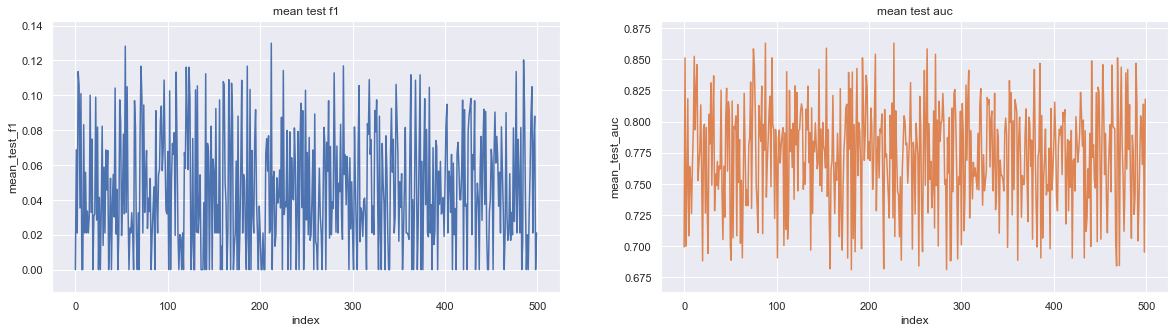

In [17]:
# Check F1 / AUC score for Random Search on Stratified Random Forest
plot_search_scores(brf_scores)

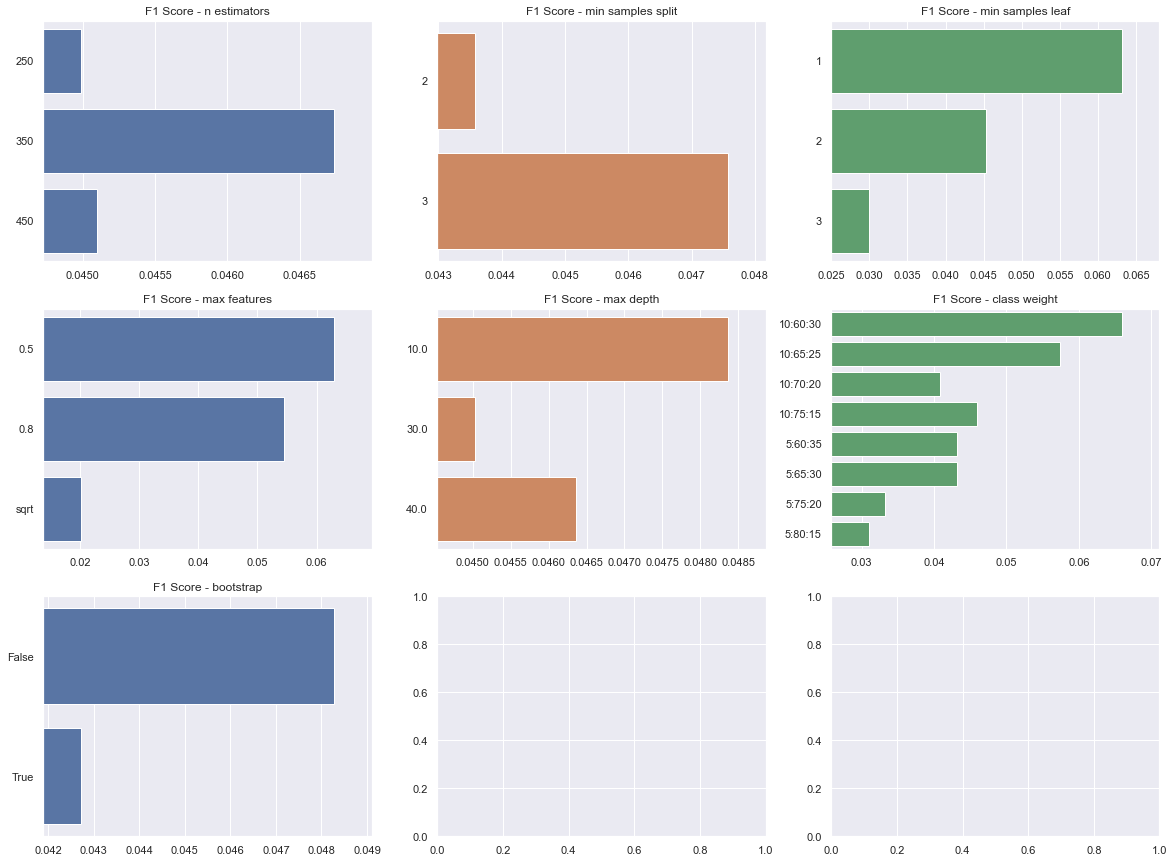

In [18]:
# Check F1 score per Parameter of Stratified Random Forest
plot_param_scores(brf_scores, which='f1')

### Random Search - Random Forest Results - Conclusions 

- Definitely the proposed stratified under sampling proportions 10:60:30 with no bootstrapping gets best result. Lucky guess was right!
- Min Samples on Leaf reflects an expected behavior, since failure values are very few, cases must be quite specific.
- Increasing the min number of samples per split seems to add value. Perhaps experimenting on additional value options can help.
- Increasing the number of estimators by much does not improve results. Best amount is 350. Note that is close to the proxy defined previously.
- Increasing max depth of estimators does not add much value. Perhaps trying lower values can help.

### Random Search - Bagg + Boost Results

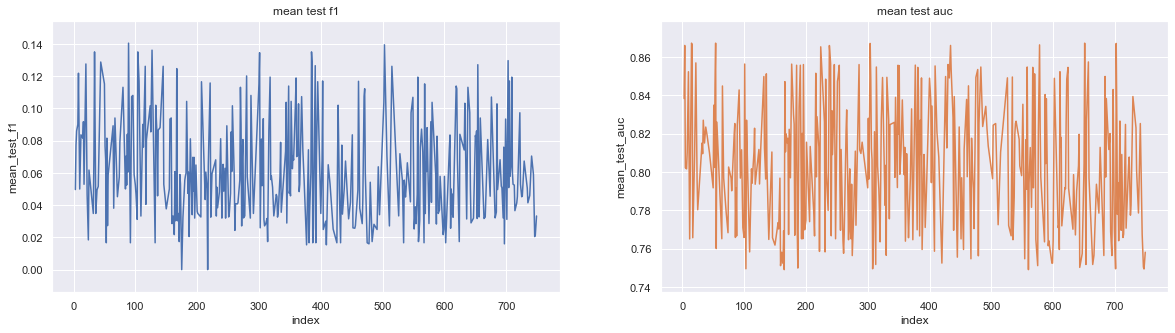

In [19]:
# Check F1 / AUC score for Random Search of Stratified Bagg + Boost
plot_search_scores(bbb_scores)

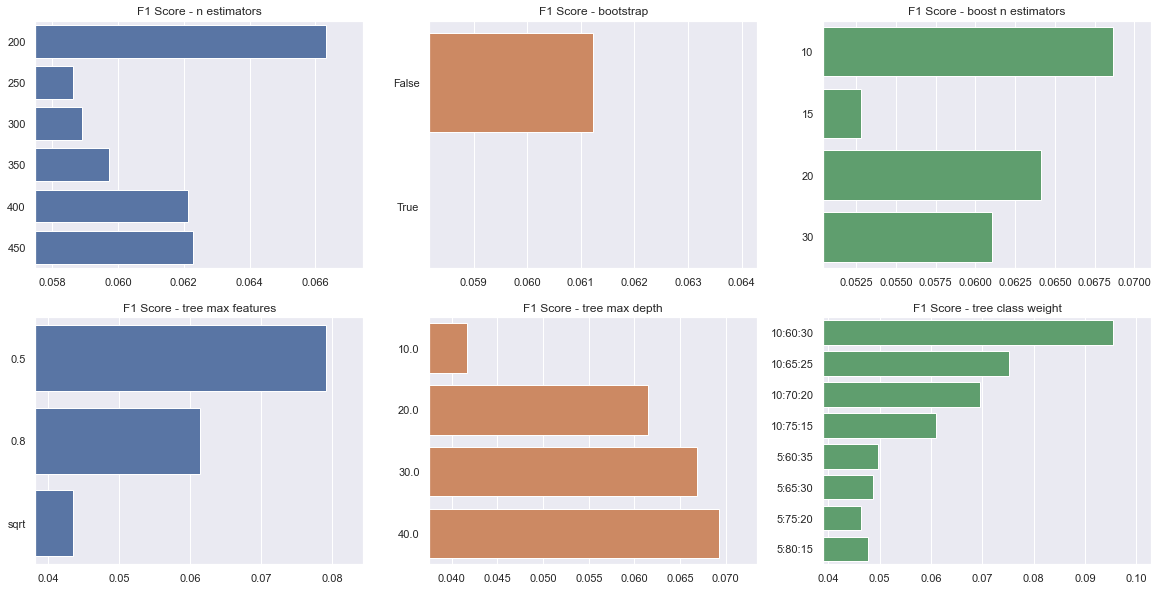

In [20]:
# Check F1 score per Parameter of Stratified Bagg + Boost
plot_param_scores(bbb_scores, which='f1')

### Random Search - Bagg + Boost Results - Conclusions 
- Definitely the proposed stratified under sampling proportions 10:60:30 with no bootstrapping gets best result.
- Increasing the number of bagging and boosting estimators by much does not improve results. Best amount is 200 and 10 respectively.
- Increasing tree depth seems to improve results.

### Random Search Analysis - Conclusions
- AUC and F1 Score (for 90% Threshold) behave similarly.
- F1 Score seems to be more sensitive to hyperparameter changes. This is expected since the problem is highly unbalanced, and F1 score makes a better job reflecting that.
- Both scores are lower than when designing the candidates. This is because of cross validation technique. As it subsamples for validation, reduces available information for training (which is already small).

---
## Best Configurations Analysis

### Configuration Analysis Prerequisites

To effectively analyze the best configuration for both ensembles (Random Forest and Bagg + Boost). The following function `get_metrics()` was built.

- It calculates values for Precision / Recall curve. Varies threshold and stores how both metrics changes.
- It calculates F1 Score for each Precision / Recall curve point as well. It will be tied to its correspondent threshold.
- For the best F1 score. Uses corresponding threshold to calculate its respective confusion matrix.
- If `plot` parameter is set to true, it will additionally plot four figures.
    - **Figure 1:** Precision / Recall curve
    - **Figure 2:** Precision vs. Recall chart (X axis is threshold)
    - **Figure 3:** F1 Score chart (X axis is threshold)
    - **Figure 4:** Confusion matrix for best F1 Score threshold.

In [23]:
# Function to get Precision / Recall curve, Best Threshold and F1 Confusion Matrix
def get_metrics(y_true, y_proba, plot=True):
    prc, rcl, thrsh = precision_recall_curve(y_true, y_proba) 
    f1 = 2 * ((prc * rcl) / (prc + rcl))
    pr_data = pd.DataFrame([thrsh, prc, rcl, f1], index=['threshold', 'precision', 'recall', 'f1']).transpose()

    id_best = pr_data['f1'].idxmax()
    thrsh_best = pr_data.loc[id_best, 'threshold']

    y_pred = list(map(lambda v: 1 if v >= thrsh_best else 0, y_proba))
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix = pd.DataFrame(conf_matrix, index=y_true.unique(), columns=y_true.unique())

    if plot:
        m_pr_data = pr_data.melt(id_vars=['threshold'], var_name='metric')

        ax = Viz.get_figure(4)
        ax[0].set_title('Precision / Recall Curve')
        sns.lineplot(data=pr_data, x='precision', y='recall', ax=ax[0])
        ax[1].set_title('Precision vs Recall')
        sns.lineplot(data=m_pr_data.query("metric != 'f1'"), x='threshold', y='value', hue='metric', ax=ax[1])
        ax[2].set_title('F1 Score')
        sns.lineplot(data=pr_data, x='threshold', y='f1', ax=ax[2])
        ax[3].set_title('Best Confusion Matrix')
        sns.heatmap(conf_matrix, vmin= 0, vmax=100, square=False, annot=True, fmt='d', ax=ax[3])
        plt.show()

    return pr_data, thrsh_best, confusion_matrix

### Best Random Forest Configuration

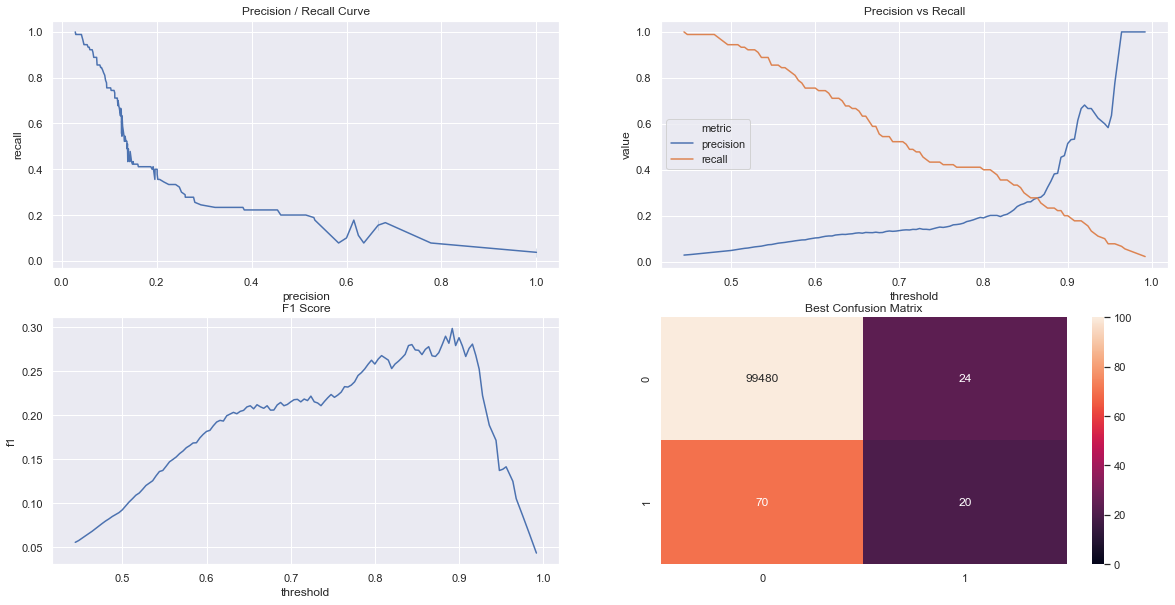

In [24]:
# Get scores (on whole Train set) for best Stratified Random Forest
strt_proba = brf_best.predict_proba(X_train)
y_proba = list(map(lambda v: v[2], strt_proba))
brf_mtrcs, brf_thrsh, brf_matrix   = get_metrics(y_train, y_proba, plot=True)

### Best Bagg + Boost Configuration

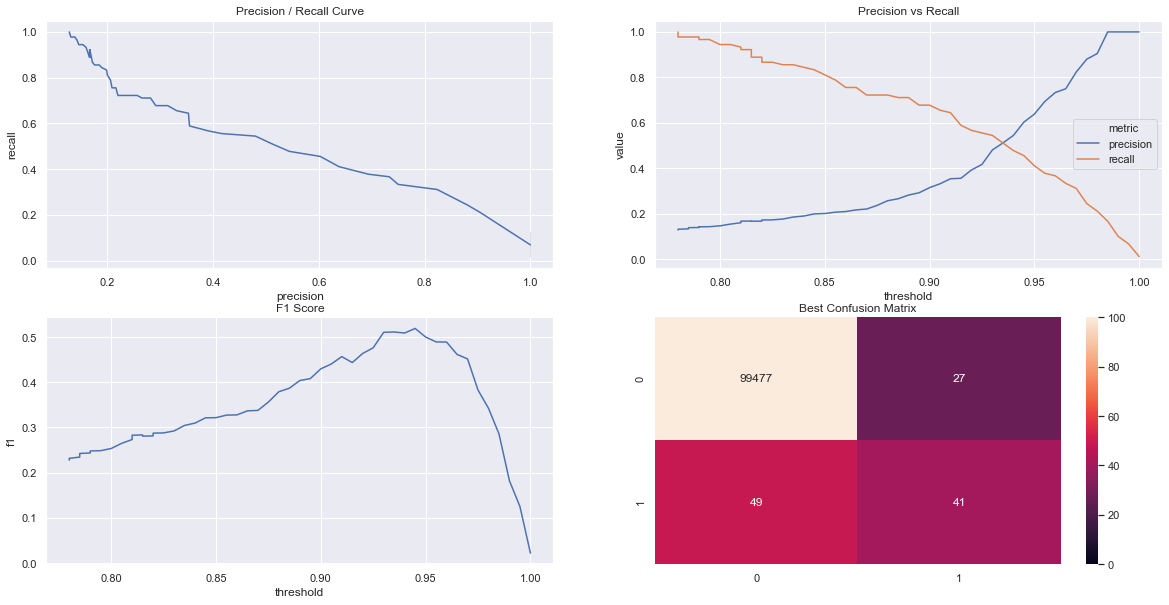

In [25]:
# Get scores (on whole Train set) for best Stratified Bagg + Boost
strt_proba = bbb_best.predict_proba(X_train)
y_proba = list(map(lambda v: v[2], strt_proba))
bbb_mtrcs, bbb_thrsh, bbb_matrix   = get_metrics(y_train, y_proba, plot=True)

### Best models configuration - Conclusions
- Performance of best models was reduced compared to results when defining candidates. This is because, training sample was reduced even more because of cross validation technique.
- Performance is expected to be higher when training with whole train set and testing on test set.
- False Negatives seems the hardest to improve, this is because of the high threshold we are working with.
- High thresholds limits the model until there is an extremely high certainty. But this actually gets the best (minimal) False Positive / False Negative ratio which is the main objective.
- From the two final candidates, we will proceed with the Stratified Bagg + Boost. It gets best results in both False Negative counts and the False Positive counts.